<h1 align="center">Introduction to Machine Learning - Course Code: 25737</h1>
<h4 align="center">Instructor: Dr. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>
<h4 align="center">Computer Assignment 3</h4>
<h4 align="center">

Question 1

</h4>

# Personal Data

In [ ]:
# Set your student number
student_number = 400101837
Name = 'Ali'
Last_Name = 'Kouchakzade'

# Rules
- You are not allowed to add or remove cells. You **must use the provided space to write your code**. If you don't follow this rule, **your Practical Assignment won't be graded**.  

- Collaboration and using the internet is allowed, but your code **must be written by yourself**. **Copying code** from each other or from available resources will result in a **zero score for the assignment**.

- You are not allowed to use `torch.nn`, `torch.optim` and any activation function and loss function implemented in torch.

In [ ]:
#!pip install numpy
#!pip install matplotlib
#!pip install torchvision
#!pip install torch

## Importing Libraries

In [ ]:
import torch
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt
from typing import Dict

## Datasets and Dataloaders

Here, we download and load the train and test `FashionMNIST` dataset with the desired transforms. Then, we define the dataloaders for `train` and `test`.

In [ ]:
train_set = FashionMNIST(root='.', train=True, download=True, transform=transforms.ToTensor())
test_set = FashionMNIST(root='.', train=False, download=True, transform=transforms.ToTensor())


Here you have to calculate the number of classes amd input dimention of the first layer (how many pixels does each image have?).

In [ ]:
## FILL HERE
input_dim , num_classes = train_set.data.shape[1] * train_set.data.shape[2] , len(train_set.classes)
print(f'number of classes is {num_classes} include {str(train_set.classes)}')
print(f'input dimention is {train_set.data.shape[1]} * {train_set.data.shape[2]} = {input_dim} ')

number of classes is 10 include ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
input dimention is 28 * 28 = 784 


In [ ]:
train_loader = DataLoader(train_set, 64, shuffle=True)
test_loader = DataLoader(test_set, 64, shuffle=True)

## Visualization

Visualize 1 random image from each class by using `plt.subplots`

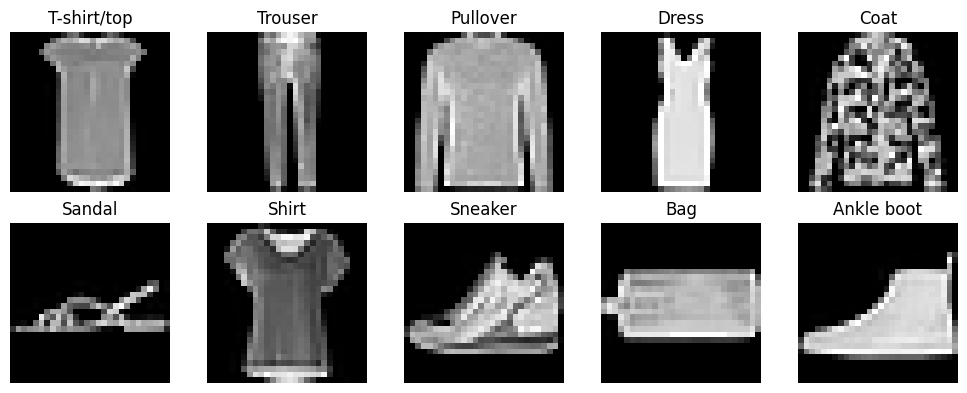

In [ ]:
plt.figure(figsize=(10,4))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(train_set.data[(train_set.targets == i).nonzero(as_tuple=True)[0][int(np.random.uniform() * 6000)],:,:],'gray')
    plt.title(train_set.classes[i])
    plt.axis('off')
plt.tight_layout()
plt.show()

## Initializing model's parameters

In this part, we create the model and initialize its parameters and store the values of these parameters in the variable `parameters` which is a dictionary including the weigths and biases of each layer.

In [ ]:
def add_linear_layer(parameters: dict, shape, device, i=None):
    """
    This function adds parameters of a linear unit of shape `shape` to the `parameters` dictionary.
    """
    n_in, n_out = shape
    with torch.no_grad():
        w = torch.zeros(*shape, device=device)
        # kaiming initialization for ReLU activations:
        bound = 1 / np.sqrt(n_in).item()
        w.uniform_(-bound, bound)
        b = torch.zeros(n_out, device=device)  # no need to (1, n_out). it will broadcast itself.
    w.requires_grad = True
    b.requires_grad = True
    # `i` is used to give numbers to parameter names
    parameters.update({f'w{i}': w, f'b{i}': b})

Now we define our neural network with the given layers and add the weights and biases to the dictionary `parameters`. **You are allowed to modify the values of the layers**.

In [ ]:
# input_dim : input dimention of the first layer, which you have calculated before.
layers = [
    (input_dim, 512),
    (512, 256),
    (256, 128),
    (128, 64),
    (64, num_classes)
]
num_layers = len(layers)
parameters = {}

# setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# adding the parameters to the dictionary
for i, shape in enumerate(layers):
    add_linear_layer(parameters, shape, device, i)

parameters.keys()

cuda


dict_keys(['w0', 'b0', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])

## Defining the required functions

In this section, we should define the required functions. For each of these functions, the inputs and the desired outputs are given and you should write all or part of the function. **You are not allowed to use the activation functions and the loss functions implemented in torch**.

Computing affine and relu outputs:

In [ ]:
def affine_forward(x, w, b):
    return x @ w + b

def relu(x):
    return torch.maximum(torch.tensor(0,device=x.device),x)

Function `model` returns output of the whole model for the input `x` using the parameters:

In [ ]:
def model(x: torch.Tensor, parameters, num_layers=num_layers):
    x = x.reshape(-1, input_dim)
    dict_keys = ['w0', 'b0', 'w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4']
    for i in range(num_layers):
        x = affine_forward(x,parameters[dict_keys[2*i+0]],parameters[dict_keys[2*i+1]])
        if i < num_layers - 1:
            x = relu(x)
    return x

Implementing cross entropy loss:

In [ ]:
def cross_entropy_loss(scores, y,lam=1):
    n = len(y) # score [64 10] - y [64]
    exp_score = torch.exp(scores)
    prob = exp_score / torch.sum(exp_score,axis=1,keepdim = True) # sum in row
    log_prob = -torch.log(prob[range(n),y])
    penalty = lam * (
        (parameters['w0'] ** 2).sum().item() / (784*512) + (parameters['w1'] ** 2).sum().item() / (512*256)
        + (parameters['w2'] ** 2).sum().item() / (256*128) + (parameters['w3'] ** 2).sum().item() / (128*64)
        + (parameters['w4'] ** 2).sum().item() / (64*10)
    )
    return torch.sum(log_prob) + penalty

Implementing a function for optimizing paramters and a function to zeroing out their gradients:

In [ ]:
def sgd_optimizer(parameters: dict, learning_rate=0.001):
    '''This function gets the parameters and a learning rate. Then updates the parameters using their
    gradient. Finally, you should zero the gradients of the parameters after updating
    the parameter value.'''
    for param in parameters.values():
        with torch.no_grad():
            param.data -= learning_rate * param.grad
            param.grad.zero_()

Training functions:

In [ ]:
def accuracy(y_pred: np.ndarray, y_true: np.ndarray):
    return np.sum(y_pred == y_true) / len(y_true)


def train(train_loader, learning_rate=0.001, epoch=None,lam=1):
    '''This function implements the training loop for a single epoch. For each batch you should do the following:
        1- Calculate the output of the model to the given input batch
        2- Calculate the loss based on the model output
        3- Update the gradients using backward method
        4- Optimize the model parameters using the sgd_optimizer function defined previously
        5- Print the train loss (Show the epoch and batch as well)
        '''

    N_train = len(train_loader.dataset)

    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculating the accuracy later
    Y = []
    Y_pred = []
    train_loss = 0

    for i, (x, y) in enumerate(train_loader):
        p = model(x.to(device), parameters)

        loss = cross_entropy_loss(p, y.to(device),lam)
        train_loss += loss.item()
        loss.backward()

        sgd_optimizer(parameters, learning_rate)

        y_pred = p.argmax(dim=-1)
        Y.append(y.numpy())
        Y_pred.append(y_pred.cpu().numpy())

    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    train_loss/= N_train
    print(f'epoch : {epoch + 1} \n loss on train : {train_loss:.4f} Accuracy of train : {acc:.4f}')
    return train_loss, acc

def validate(loader, epoch=None, set_name=None):
    '''This function validates the model on the test dataloader. The function goes through each batch and does
    the following on each batch:
        1- Calculate the model output
        2- Calculate the loss using the model output
        3- Print the loss for each batch and epoch

    Finally the function calculates the model accuracy.'''
    total_loss = 0
    N = len(loader.dataset)

    # Creating empty lists Y and Y_pred to store the labels and predictions of each batch
    # for calculateing the accuracy later
    Y = []
    Y_pred = []
    for i, (x, y) in enumerate(loader):
        with torch.no_grad():
            p = model(x.to(device), parameters)
            loss = cross_entropy_loss(p, y.to(device))
            total_loss += loss.item()
            y_pred = p.argmax(dim=-1)
            Y.append(y.numpy())
            Y_pred.append(y_pred.cpu().numpy())
    Y = np.concatenate(Y)
    Y_pred = np.concatenate(Y_pred)
    acc = accuracy(Y_pred, Y)
    total_loss /= N
    print(f' loss on test  : {total_loss:.4f} Accuracy of {set_name}  : {acc:.4f}')

    return total_loss, acc


In [ ]:
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [ ]:
def train_model(dataloaders, num_epochs, learning_rate=0.001,lam=1, model_name='pytorch_model'):
    '''This function trains the model for the number of epochs given and stores, calculates and prints the train
    and test losses and accuracies. Finally, it plots the accuracy and loss history for training and test sets'''
    train_loader, test_loader = dataloaders

    for epoch in range(num_epochs):
        ## FILL HERE
        ## You should calculate the train and test loss and accuracies for each epoch and add them to
        ## the lists `train_losses`, `test_losses`, `train_accuracies` and `test_accuracies`
        train_loss , train_acc = train(train_loader,learning_rate,epoch,lam=lam)
        train_losses.append(train_loss) , train_accuracies.append(train_acc)

        test_loss , test_acc = validate(test_loader,epoch,'test')
        test_losses.append(test_loss) , test_accuracies.append(test_acc)

    plt.figure(figsize=(11,4))
    plt.subplot(1,2,1)
    plt.title('losses vs epoch')
    plt.plot(range(num_epochs),train_losses,label='train')
    plt.plot(range(num_epochs),test_losses,label='test')
    plt.legend()
    plt.subplot(1,2,2)
    plt.title('accuracy vs epoch')
    plt.plot(range(num_epochs),train_accuracies,label='train')
    plt.plot(range(num_epochs),test_accuracies,label='test')
    plt.legend()

epoch : 1 
 loss on train : 1.0504 Accuracy of train : 0.6116
 loss on test  : 0.5949 Accuracy of test  : 0.7860
epoch : 2 
 loss on train : 0.5610 Accuracy of train : 0.8136
 loss on test  : 0.4859 Accuracy of test  : 0.8238
epoch : 3 
 loss on train : 0.4785 Accuracy of train : 0.8457
 loss on test  : 0.4457 Accuracy of test  : 0.8425
epoch : 4 
 loss on train : 0.4387 Accuracy of train : 0.8617
 loss on test  : 0.3967 Accuracy of test  : 0.8554
epoch : 5 
 loss on train : 0.4134 Accuracy of train : 0.8718
 loss on test  : 0.4610 Accuracy of test  : 0.8232
epoch : 6 
 loss on train : 0.3972 Accuracy of train : 0.8790
 loss on test  : 0.3817 Accuracy of test  : 0.8622
epoch : 7 
 loss on train : 0.3839 Accuracy of train : 0.8844
 loss on test  : 0.4015 Accuracy of test  : 0.8561
epoch : 8 
 loss on train : 0.3704 Accuracy of train : 0.8898
 loss on test  : 0.3553 Accuracy of test  : 0.8724
epoch : 9 
 loss on train : 0.3613 Accuracy of train : 0.8948
 loss on test  : 0.3528 Accuracy o

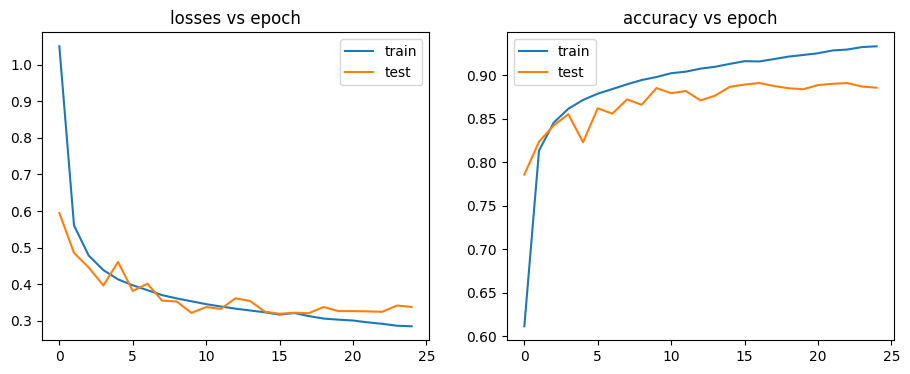

In [ ]:
train_model([train_loader, test_loader], num_epochs=25, learning_rate=0.001,lam=80)

In [ ]:
print(f'Final test accuracy: {test_accuracies[-1] * 100:.2f} % ')

Final test accuracy: 88.59 % 


## Visualization of the labels and predictions

In this section, you should visual one image from each class and show both the actual label and the predicted label for that image.

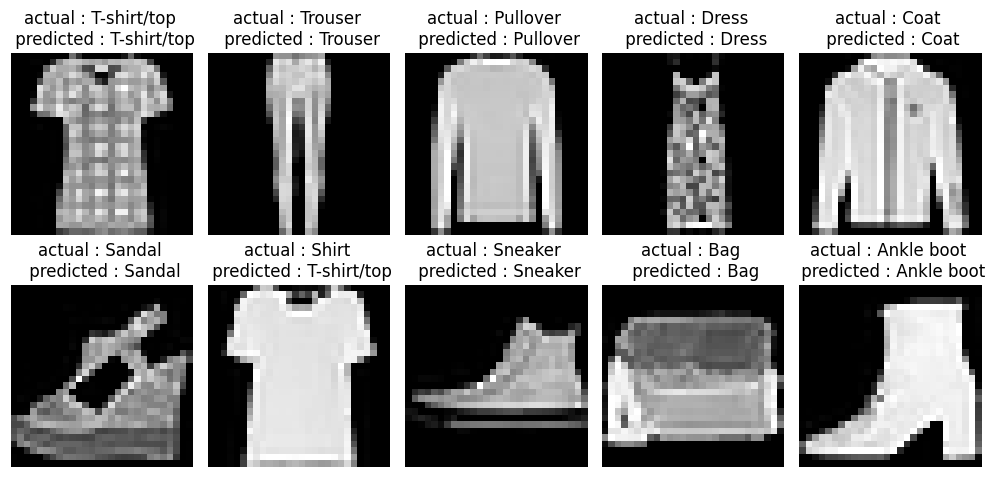

In [ ]:
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    img = test_set.data[(test_set.targets == i).nonzero(as_tuple=True)[0][int(np.random.uniform() * 1000)],:,:]
    img = img.to(torch.float32)
    p = model(img.reshape(1,-1).to(device),parameters)
    y_pred = p.argmax(dim=-1)
    plt.imshow(img,'gray')
    plt.title(f'actual : {test_set.classes[i]} \n predicted : {test_set.classes[y_pred]}')
    plt.axis('off')
plt.tight_layout()
plt.show()